<a href="https://colab.research.google.com/github/mcnica89/kInARow/blob/master/Connect4_Jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot  as plt
import jax
import time
import functools

#This allows us to use 64 bit types
#We want this for our bitboard representations of game states
jax.config.update("jax_enable_x64", True)

#A bitboard is our representation of a subset of pieces on the board
#We will use the bits of 64 bit integers to do this
BitBoard = jnp.uint64

#We use "bb" in the comments to stand for "BitBoard"

#Size of the board
N_Col = 7
N_Row = 6

#Since we use 64 bit BitBoards, we can have at most 64 positions on the board 
assert N_Col*N_Row <= 64 

#Global variable with whether or not to print tests
ShowTests = True

# BitBoard Helper functions

## BitBoard <-> Arrays and drawGame

x = bitboardToArray(1+2+4):
 [[ True  True  True False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]]
arrayToBitboard(x): 7


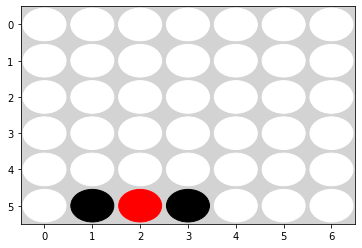

In [13]:
#SinglePieces is an important global variable often used
#An (N_Row,N_Col) array whose (i,j) entry contains the bitboard for the single pieces at location (i,j)
SinglePieces = jnp.array( [[ 2**(col + N_Col*row)  for col in range(N_Col)] for row in range(N_Row)], dtype=BitBoard)

@jax.jit
def arrayToBitboard(boolean_array):
    '''Converts a Boolean aray of size (N_Row,N_col) to a BitBoard'''
    #Input: An (...,N_Row,N_Col) array of booleans
    #Output: A single bitboard
    return jnp.sum(jnp.sum(boolean_array*SinglePieces, axis=-1),axis=-1)

def bitboardToArray(x_bitboard):
    '''Convert from the bitboard reprensentation to an N_Row,N_Col jax array'''
    #Input: A single bitboard
    #Output: An array (...,N_Row,N_Col) of boolean
    #Rmk: Uses numpy since some jax fromiter is not implemented yet
    _iter = (char == '1' for char in np.binary_repr(x_bitboard,N_Row*N_Col))
    _array = np.fromiter(_iter, dtype=bool)
    return jnp.reshape( jnp.flip(_array), (N_Row,N_Col),  order='C')

if ShowTests:
  x = bitboardToArray(1+2+4)
  print("x = bitboardToArray(1+2+4):\n", x)


if ShowTests:
  print("arrayToBitboard(x):", arrayToBitboard(x))

#A GameState is an array of size (2,) of BitBoards 
#This consists of the positions for pieces for two players

def drawGame(game_state,  player_color = ['red','black']):
  '''Use matplotlib to draw the board in text given the bitboards for player 1 and player 2'''
  #Input: A game_state of shape (2,) with two bitboards
  #Output: Draws a graph with the game 

  fig, ax = plt.subplots() 
  plt.xlim(-0.5,N_Col-0.5)
  plt.ylim(N_Row-0.5,-0.5)
  ax.patch.set_facecolor('lightgrey')

  piece_array = jnp.array( [bitboardToArray(game_state[0]),bitboardToArray(game_state[1])] ) 

  for x in  range(N_Col):
    for y in range(N_Row):
      outline = plt.Circle((x,y), 0.45, color='white')
      ax.add_patch(outline)

      for player_ix in range(2):
        if piece_array[player_ix, y,x]:
          piece = plt.Circle((x,y), 0.45, color=player_color[player_ix])
          ax.add_patch(piece)


  #for player_ix in range(2):
  #  row_coords, col_coords = np.where(bitboardToArray(game_state[player_ix]))
  #  for (x,y) in zip(col_coords,row_coords):
  #    piece = plt.Circle((x,y), 0.45, color=player_color[player_ix])
  #    ax.add_patch(piece)

  plt.show()

if ShowTests:
  game_state = jnp.array([SinglePieces[N_Row-1,2],SinglePieces[N_Row-1,1] | SinglePieces[N_Row-1,3]]) 
  drawGame(game_state)  

## isSubset and isEmptyIntersection

In [14]:
@jax.jit
def isSubset(bb_sub,bb_super):
    '''Returns TRUE if the bitboard bb_sub is a subset of bb_super'''
    #Input: Two bitboard arrays which are brodcastable together
    #Output: A bolean array with isSubset? answered in each spot
    #Rmk: Works with arrays via broadcasting
    return jnp.bitwise_and(bb_sub,jnp.bitwise_not(bb_super)) == 0

@jax.jit
def isEmptyIntersection(bb_sub,bb_super):
    '''Returns TRUE if the bitboard bb_sub and bb_super have empty intersection'''
    #Input: Two bitboard arrays which are brodcastable together
    #Output: A bolean array with isEmptyIntersection? answered in each spot
    #Rmk: Works with arrays via broadcasting
    return jnp.bitwise_and(bb_sub,bb_super) == 0


if ShowTests:
  x = jnp.array([1+2+4,32+64,2], dtype=BitBoard)
  y = jnp.array([1+2+4+8, 32+128,1+8], dtype=BitBoard)
  print("isSubset tests: ", isSubset(x,y)) #Should return [True,False,False]
  print("isEmptyIntersection tests: ", isEmptyIntersection(x,y)) #Should return [False,False,True]  

isSubset tests:  [ True False False]
isEmptyIntersection tests:  [False False  True]


# Connect 4 Helper Functions

## possibleMoves

Test 1: All moves from this state


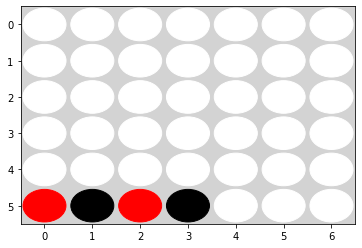

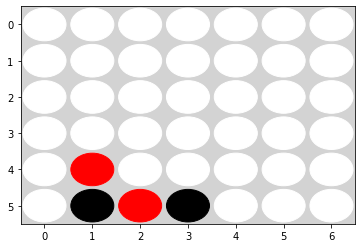

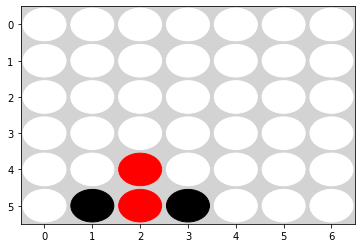

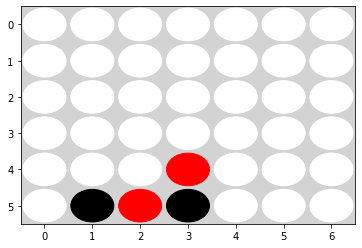

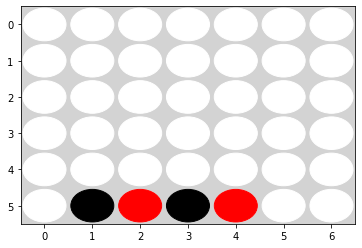

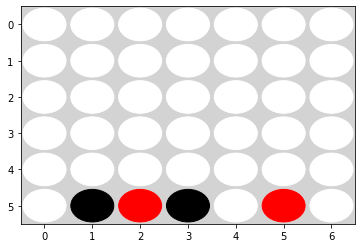

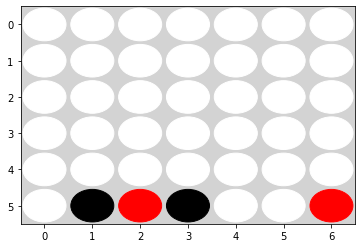

Test 2: Play move 0 over and over again
Legal? True


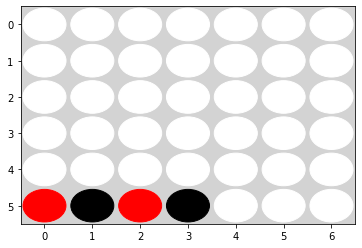

Move index:  [4 4 4 4 5 5 5]
Legal? True


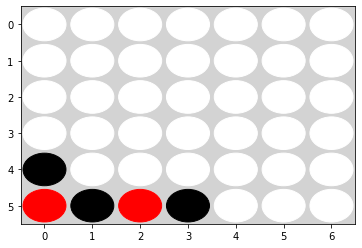

Move index:  [3 4 4 4 5 5 5]
Legal? True


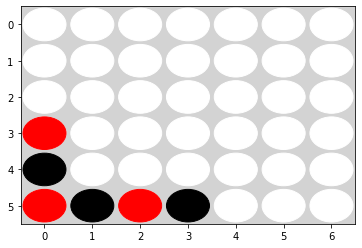

Move index:  [2 4 4 4 5 5 5]
Legal? True


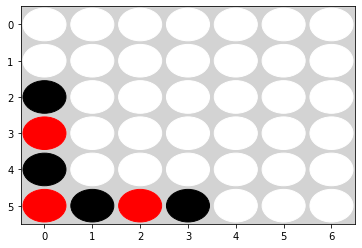

Move index:  [1 4 4 4 5 5 5]
Legal? True


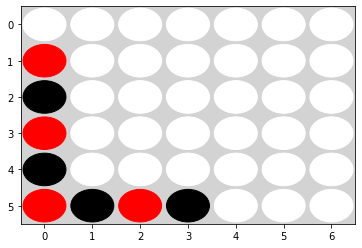

Move index:  [0 4 4 4 5 5 5]
Legal? True


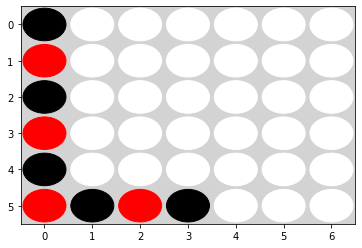

Move index:  [5 4 4 4 5 5 5]
Legal? False


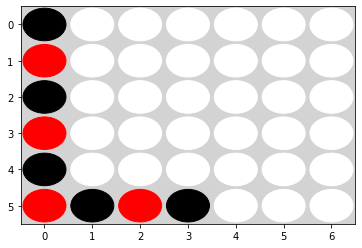

Move index:  [5 4 4 4 5 5 5]


In [15]:
#In Connect4 the max number of possible moves is just the number of columns
N_Possible_Moves = N_Col

@jax.jit
def possibleMoves(player_ix, game_state):
  '''Returns all the allowed moves from a given gamestate when it is plyr_ix's turn'''
  #Input: 
  #  plyr_ix = Either 0 or 1
  #  game_state = An bb array of shape (...,2) with the current positions 
  #               of the two players 
  #Output: A tuple moves, legal
  # new_game_states = A bb array of shape (...,N_Possible_Moves,2) with the 
  #        postion after all the possible moves
  # legal = A boolean array of shape (...,N_Possible_Moves) with whether or not 
  #         each move is legal 

  #Rmks: 
  # 1. The function assumes the dimension 2, is LAST dimension (uses axis=-1)
  # 2. Uses the SinglePieces global variable for the locations of all the pieces

  #Assume that the shape of game_state is shape: (pre-shape,2)
  #shape(game_state) = (pre-shape,2)

  #Locations played by either player. 
  # shape: (pre-shape)
  played_bb = jnp.sum(game_state, axis=-1, dtype=BitBoard)

  #Boolean array of with whether or not each piece has been played  
  # shape: (pre-shape,N_Row,N_Col)
  unplayed_locs = isEmptyIntersection(played_bb[...,jnp.newaxis,jnp.newaxis], SinglePieces)

  #Bb array of with which piece hasn't been played
  #shape: (pre-shape,N_Row,N_Col) 
  unplayed_bb = unplayed_locs*SinglePieces

  #Finds the maximum unplayed piece in each row. 
  #  Since in our setup the maximum is toward the bottom, this is the piece that
  #  gravity would settle a dropped piece at
  #shape: (pre-shape,N_Col)
  max_unplayed_bb = jnp.amax(unplayed_bb, axis=-2)

  #This is has shape (pre-shape,N_Col) with the row index of each legal move
  move_ix = (jnp.argmax(jnp.logical_not(unplayed_locs), axis=-2) - 1) %N_Row


  #Create a board state where player 0 is max_unplayed_bb and player 1 is empty
  # shape: (pre-shape, N_Col, 2)
  p0_move = jnp.stack([max_unplayed_bb,jnp.zeros_like(max_unplayed_bb)], axis=-1) 
  
  # For the other player we have to swap these
  # We put this if statement into lax.cond instead of "if" so it is jit-able
  moves = jax.lax.cond(player_ix==0, lambda x:x, lambda x:jnp.flip(x,axis=-1), p0_move)
  
  #Add the moves to the game_state and ensure correct brodcasting
  # Note: we use | instead of + for safety/speed...it shouldn't matter!
  # shape: (pre-shape, N_Col, 2)
  new_game_states = game_state[...,jnp.newaxis,:] | moves

  
  #A move is legal as long as at least one of these is non-zero:
  # shape: (pre-shape,N_Col)
  legal = (max_unplayed_bb > 0)
  
  return new_game_states, legal, move_ix

if ShowTests:
  player_ix = 0
  game_state = jnp.array([SinglePieces[N_Row-1,2],SinglePieces[N_Row-1,1] | SinglePieces[N_Row-1,3]]) 
  print("Test 1: All moves from this state")
  new_game_states, legal, _ = possibleMoves(player_ix, game_state)
  for i in range(N_Col):
    drawGame(new_game_states[i])
 
  print("Test 2: Play move 0 over and over again")
  for t in range(N_Row+1):
    print(f"Legal? {legal[0]}")
    game_state = new_game_states[0]
    drawGame(game_state)
    
    player_ix = 1- player_ix
    new_game_states, legal, move_ix = possibleMoves(player_ix, game_state)
    print("Move index: ", move_ix)
    

## FourInALine and FourInALineThreats

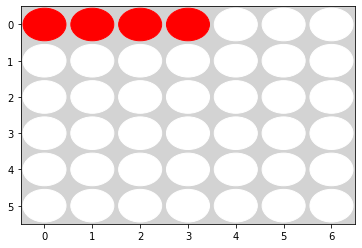

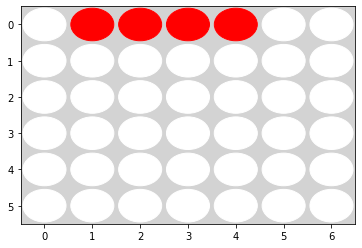

[1 0 0]


In [16]:
def GenerateKinARow(k):
    '''Return an array with all the boards that contain k pieces in a line'''
    #Input: k an integer
    #Output: A bb vector of shape (N_k_in_a_lines,) with all the k in a lines
    #Rmk: Uses some numpy functions for convenience in the loop
    return jnp.array(
        [ np.sum([SinglePieces[x,y+i] for i in range(k)]) for x,y in np.ndindex(N_Row,N_Col-k+1)] +
        [ np.sum([SinglePieces[x+i,y] for i in range(k)]) for x,y in np.ndindex(N_Row-k+1,N_Col)] +
        [ np.sum([SinglePieces[x+i,y+i] for i in range(k)]) for x,y in np.ndindex(N_Row-k+1,N_Col-k+1)] +
        [ np.sum([SinglePieces[x+i,N_Col-1-(y+i)] for i in range(k)]) for x,y in np.ndindex(N_Row-k+1,N_Col-k+1)]
        ,dtype=BitBoard)

FourInALine = GenerateKinARow(4)    

@jax.jit
def numConnectFour(bb):
    '''Return the number of 4 in a lines in a single BitBoard'''
    #Input: A bitboard (or an array with bit board arrays)
    #Output A boolean (or an array of the same shape of boolean)
    return jnp.sum( isSubset( FourInALine, bb[...,jnp.newaxis]), axis=-1)    

@jax.jit
def hasConnectFour(bb):
  '''Return whether or not a single BitBoard has a 4 in a line'''
  return numConnectFour(bb) > 0 


if ShowTests:
  drawGame(jnp.array([FourInALine[0],0],dtype=BitBoard))
  drawGame(jnp.array([FourInALine[1],0],dtype=BitBoard))
  #Should return True, False, False
  print( numConnectFour( jnp.array( [FourInALine[0],0,2],dtype=BitBoard) ) )

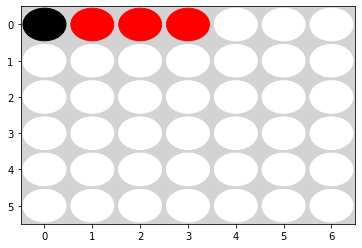

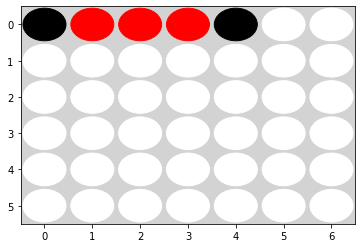

[1 0]


In [17]:
def GenerateKinARowThreats(k):
    '''Return an array with all the threats to get k pieces in a line.
    A threat means you are one piece away from getting a k in a line.'''
    #Input: k an integer
    #Output: A bb vector of shape (N_k_in_a_lines*k,2) with all the k in a line threats
    #       The [:,0] entry contains the pattern with k-1 pieces
    #       The [:,1] entry conains the missing piece
    #Rmk: Uses some numpy functions for convenience in the loop
    return jnp.array(
        [ [np.sum([SinglePieces[x,y+i] for i in range(k) if i != z]),SinglePieces[x,y+z]] for x,y,z in np.ndindex(N_Row,N_Col-k+1,k)] +
        [ [np.sum([SinglePieces[x+i,y] for i in range(k) if i != z]),SinglePieces[x+z,y]] for x,y,z in np.ndindex(N_Row-k+1,N_Col,k)] +
        [ [np.sum([SinglePieces[x+i,y+i] for i in range(k) if i != z]),SinglePieces[x+z,y+z]] for x,y,z in np.ndindex(N_Row-k+1,N_Col-k+1,k)] +
        [ [np.sum([SinglePieces[x+i,N_Col-1-(y+i)] for i in range(k) if i != z]),SinglePieces[x+z,N_Col-1-(y+z)]] for x,y,z in np.ndindex(N_Row-k+1,N_Col-k+1,k)]
        ,dtype=BitBoard)
    
FourInALineThreats = GenerateKinARowThreats(4)

@jax.jit
def numConnectFourThreat(player_ix,game_state):
  '''Returns whether or not a given game_state has a Connect4 threat for player_ix'''
  #Input: player_ix = whose turn it is
  #       game_state = an array of shape (...,2) with the game state
  #Ouput: An integer array of shape (...) with how many threats are there

  #Check if the active player has the 3 out of 4 in the threat
  # shape = (...,N_threats)
  has_3_lined_up = isSubset(FourInALineThreats[:,0],game_state[...,player_ix, jnp.newaxis])

  #Check if the non-active player is blocking the last piece
  # shape = (..., N_threats)
  last_1_blocked = isSubset(FourInALineThreats[:,1],game_state[...,1-player_ix, jnp.newaxis])
  
  #The threat is real when we have 3 and the last one is unblocked
  # shape = (..., N_threats)
  threat_is_real = jnp.logical_and(has_3_lined_up, jnp.logical_not(last_1_blocked))
  
  #Return the number of threats!
  return jnp.sum(threat_is_real, axis=-1)

@jax.jit
def hasConnectFourThreat(player_ix,game_state):
  return numConnectFourThreat(player_ix,game_state) > 0 

if ShowTests:
  x = FourInALineThreats[0].at[1].set(1+16)
  drawGame(FourInALineThreats[0])
  drawGame(x)
  #Should return True, False
  print( numConnectFourThreat(0, jnp.array( [FourInALineThreats[0],x] ) ) )
   

In [78]:
#Second version of the threats
def GenerateKinARowThreats2(k):
    '''Return an array of shape (4k,N_Row,N_Col) with the bitboards of the 4k threats at 
    the location N_Row,N_Col'''
    #Input: k an integer
    #Output: An array of bitboards
    #Rmk: Uses some numpy functions for convenience in the loop
    DirX = [0,1,1,1]
    DirY = [1,0,1,-1]
    FullBoard = jnp.sum(SinglePieces) 
    def threat_bb_all_info(i,j,dir,off):
      #Returns the threat bitboard at location i,j in direction d with offset o
      # i \in [0,N_Row), j \in [0,N_Col)
      # dir \in [0,4) (four directions: left-right, up-down, two diagonals)
      # off \in [0,k) (offset: where in the connect 4 the spot (i,j) is)
      #OR returns a full bitboard if the threat does not fit on the board
      if 0 <= i-off*DirX[dir] < N_Row and 0 <= i+(k-1-off)*DirX[dir] < N_Row and 0 <= j-off*DirY[dir] < N_Col and 0 <= j+(k-1-off)*DirY[dir] < N_Col:
        return np.sum([SinglePieces[i+ (ell-off)*DirX[dir], j+(ell-off)*DirY[dir]] for ell in range(k) if ell != off])
      else:
        return FullBoard
    def treats_bb_at_loc(i,j):
      return [threat_bb_all_info(i,j,dir,off) for dir in range(4) for off in range(k)]

    threats_N_Row_by_N_Col_by_4k = jnp.array([[ treats_bb_at_loc(i,j) for j in range(N_Col)] for i in range(N_Row)])
    return jnp.transpose(threats_N_Row_by_N_Col_by_4k, (0,1,2))

FourInALineThreats2 = GenerateKinARowThreats2(4)

# SimpleAIs and Simulate Game

In [88]:
@jax.jit
def randomAI(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that plays randomly'''
  random_scores = jax.random.uniform(key, jnp.shape(legal) )
  score = (random_scores)*legal
  score = jnp.where(legal, score, jnp.nan)
  return jnp.nanargmax(score, axis=-1)

@jax.jit
def randomPlusAI(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that will score or block a connect 4 if able, or else play randomly'''
  random_scores = jax.random.uniform(key, jnp.shape(legal) )
  num_connect4 =  numConnectFour(new_game_states[...,player_ix])
  num_threat = jnp.clip(numConnectFourThreat(1-player_ix,new_game_states),a_min=0,a_max=10)
  score = (1000*num_connect4 +10*(10-num_threat) + random_scores)*legal
  score = jnp.where(legal, score, jnp.nan)
  return jnp.nanargmax(score, axis=-1)

@jax.jit
def randomPlusAI2(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that will score or block a connect 4 if able, or else play randomly'''
  random_scores = jax.random.uniform(key, jnp.shape(legal) )
  #shape (...,N_Col,16)
  move_threats = FourInALineThreats2[move_ix,jnp.arange(N_Col),:]
  
  #shape = (...,2,N_Col)
  has_threat = jnp.any(isSubset(move_threats[...,jnp.newaxis,:,:],game_state[...,jnp.newaxis,jnp.newaxis]),axis=-1)
  
  score = 100*has_threat[...,player_ix,:]+10*has_threat[...,1-player_ix,:] + random_scores
  score = jnp.where(legal, score, jnp.nan)
  return jnp.nanargmax(score, axis=-1) 

def humanAI(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that asks the human what to do'''
  print("Which column would you like to play in")
  raw_input = input()
  play_col = np.clip(int(raw_input),0,N_Row)
  return play_col

def simulateGame(AIs, starting_player = 0, verbose = True, key=None):
  '''Simulate a game of connect 4'''
  #Input: An list AIs = [AI_Red, AI_Black] with the two AIs to use
  #Ouput: An integer from {+1,0,-1} with who won: (2*player_ix_who_won - 1) or 0 for a tie
  PlayerNames = ['Red','Black']
  if key == None:
    key = jax.random.PRNGKey(int(time.time()))

  #Initailize game_state and whose turn it is
  game_state = jnp.zeros(2,dtype=BitBoard)
  player_ix = 1 - starting_player
  
  for i in range(N_Col*N_Row+1):
    key, subkey = jax.random.split(key)
    player_ix = 1 - player_ix
    if verbose: drawGame(game_state)
    new_game_states, legal, move_ix = possibleMoves(player_ix,game_state)
    
    if np.all(legal == 0):
      if verbose: print(f"Tie game!")
      return 0
      break

    #Stuff fed into the AI
    AI_info = (player_ix,game_state,new_game_states,legal,move_ix,subkey)
    AI_choice = AIs[player_ix](*AI_info)
    
    game_state = new_game_states[AI_choice]
    if hasConnectFour(game_state[player_ix]):
      if verbose: print(f"The {PlayerNames[player_ix]} player wins!")
      if verbose: drawGame(game_state)
      return 2*player_ix - 1
      break


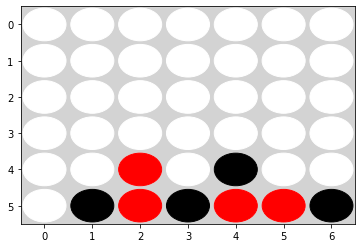

here!
(7, 16)


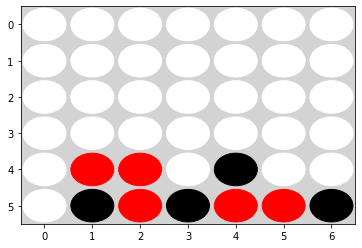

here!
(7, 16)


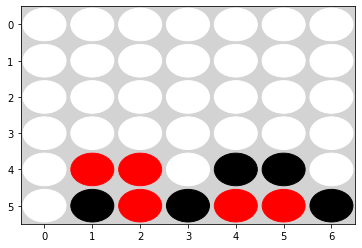

here!
(7, 16)


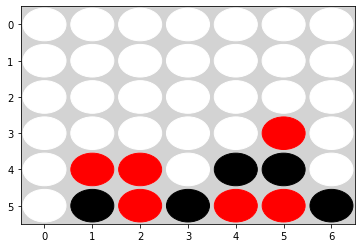

here!
(7, 16)


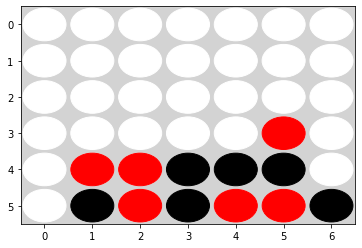

here!
(7, 16)


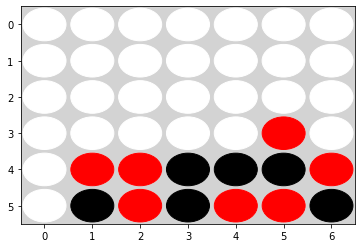

here!
(7, 16)


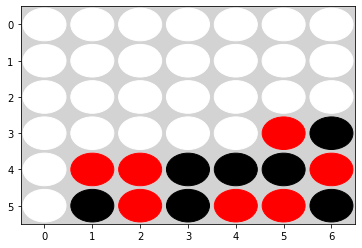

here!
(7, 16)


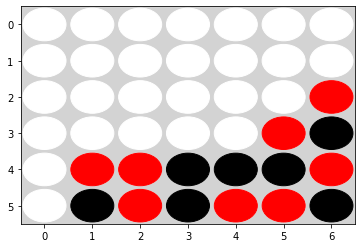

here!
(7, 16)


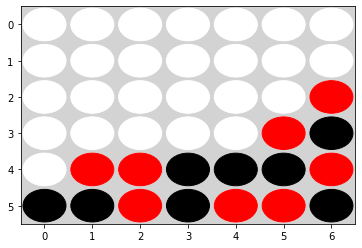

here!
(7, 16)


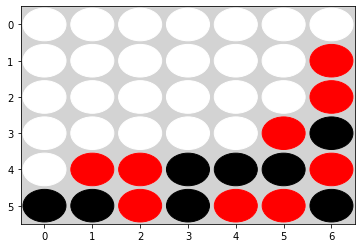

here!
(7, 16)


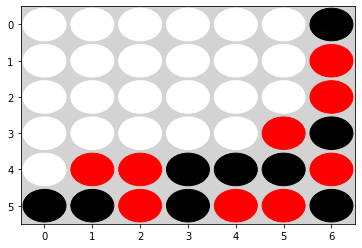

here!
(7, 16)


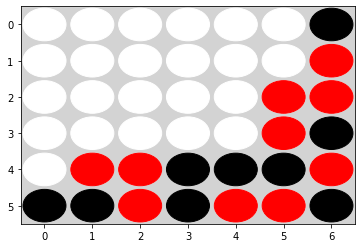

here!
(7, 16)


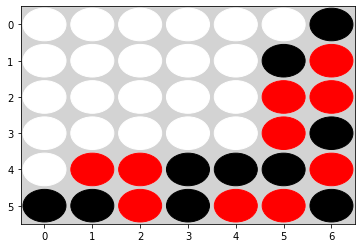

here!
(7, 16)


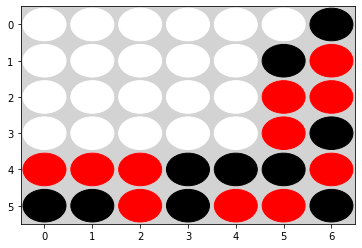

here!
(7, 16)


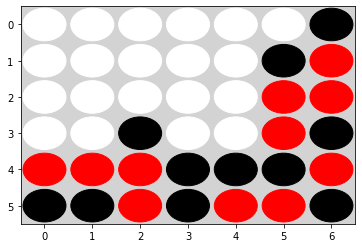

here!
(7, 16)


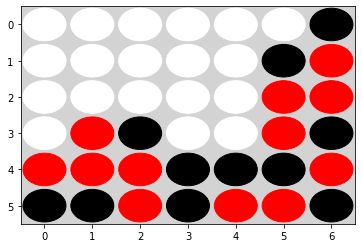

here!
(7, 16)


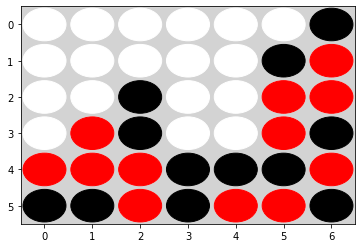

here!
(7, 16)


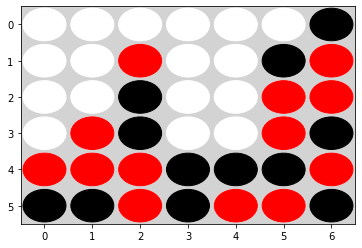

here!
(7, 16)


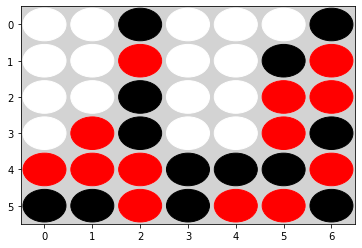

here!
(7, 16)


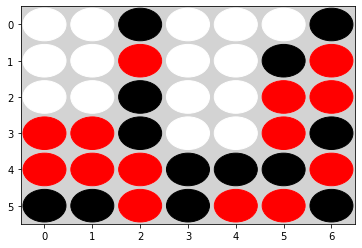

here!
(7, 16)


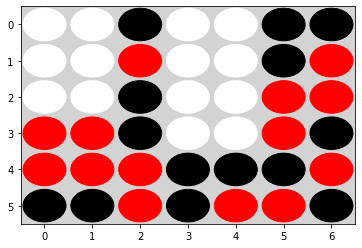

here!
(7, 16)


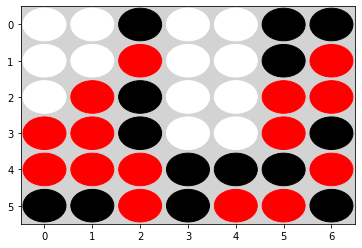

here!
(7, 16)


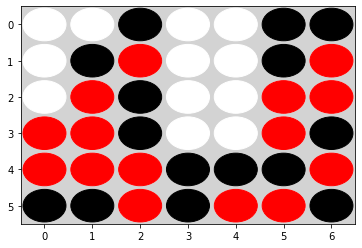

here!
(7, 16)


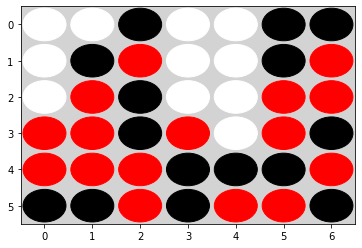

here!
(7, 16)


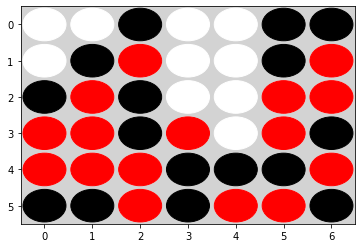

here!
(7, 16)


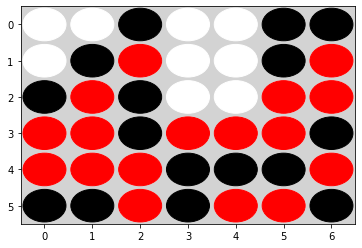

here!
(7, 16)


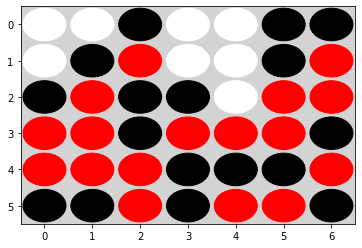

here!
(7, 16)


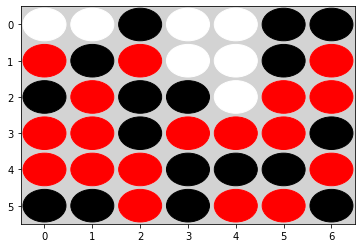

here!
(7, 16)


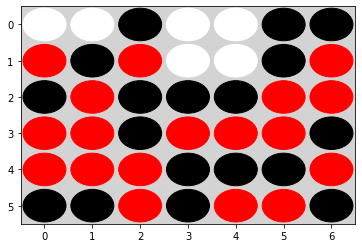

here!
(7, 16)


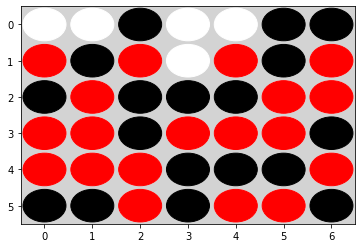

here!
(7, 16)


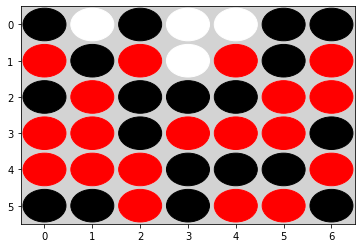

here!
(7, 16)


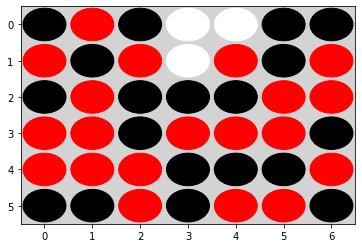

here!
(7, 16)


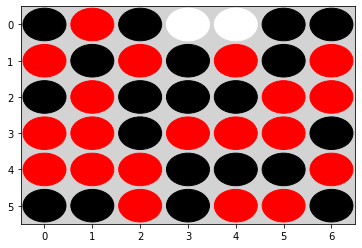

here!
(7, 16)
The Red player wins!


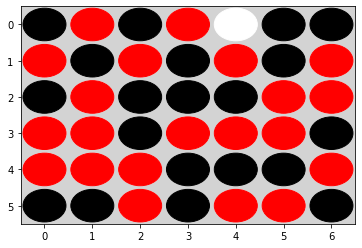

-1

In [85]:
simulateGame([randomPlusAI2,randomPlusAI2], verbose=True)

In [94]:
%timeit simulateGame([randomPlusAI,randomPlusAI], verbose=False)

10 loops, best of 5: 82.9 ms per loop


In [93]:
%timeit simulateGame([randomPlusAI2,randomPlusAI2], verbose=False)

10 loops, best of 5: 79.6 ms per loop


In [ ]:
N_games = 10
score=0
"RandomAI vs RandomPlusAI"
key = jax.random.PRNGKey(int(time.time()))
for i in range(N_games):
  key,subkey = jax.random.split(key)
  score += simulateGame([randomAI,randomAI], verbose=False,key=subkey)
  
print(f"Average score after {N_games} games is {score/N_games}")

Average score after 10 games is 0.0


# Simulating Games in Batches

In [63]:
@functools.partial(jax.jit, static_argnums=(0,1,2))
def simulateGameBatch(N_Batch, AI_0, AI_1, key, start_player=0,  start_state = jnp.zeros(2, dtype=BitBoard)):
  '''Simulate a batch game of connect 4 from a given start_state'''
  #Input: 
  #       N_Batch = Number of games to run as the batch size
  #       AI_0, AI_1 = AI functions for the the two players
  #       key = A Jax random key (passed to the AIs for making random choices)
  #       start_player = Which player to start with
  #       start_state = where to start the games. A defaulut of jnp.zeros(2) will run N_Batch games
  #               The shape of start_state must be (pre-shape,2)
  #   
  #Ouput: An array of size (N_Batch,pre-shape) consisting of +1,-1 or 0
  #Rmk: Written so that it is jit-able for extra fast simulations.
  
  def one_turn_update(game_info):
    turn, player_ix, key, game_state, game_winner, game_inprogress = game_info
    
    #Update basic info
    turn += 1
    player_ix = 1 - player_ix
    key, subkey = jax.random.split(key)
    
    #Get possible new game states
    new_game_states, legal, move_ix = possibleMoves(player_ix, game_state)
    
    #Get the AI to choose a move
    AI_info = (player_ix,game_state,new_game_states,legal,move_ix,subkey)
    #Have to use a lax.cond here as JAX complains about AIs[player_ix]
    AI_choice = jax.lax.cond(player_ix == 0, AI_0, AI_1, *AI_info)
    
    #Update the gae state by taking the choice made
    game_state = jnp.squeeze(jnp.take_along_axis(new_game_states, AI_choice[...,jnp.newaxis,jnp.newaxis], axis=-2),axis=-2) #*game_inprogress
    
    has_new_connect4 = jnp.logical_and(hasConnectFour(game_state[...,player_ix]), game_inprogress)  
    game_winner += has_new_connect4*(2*player_ix - 1)
    game_inprogress = jnp.logical_and(jnp.logical_not(has_new_connect4), game_inprogress)
    
    return turn, player_ix, key, game_state, game_winner, game_inprogress

  def keep_simulating_cond(game_info):
    turn, player_ix, key, game_state, game_winner, game_inprogress = game_info
    return turn < N_Row*N_Col+1 #jnp.any(game_inprogress) and 

  #if key == None:
  #  key = jax.random.PRNGKey(int(time.time()))

  tile_shape = [N_Batch]+[1]*len(start_state.shape)
  game_state = jnp.tile(start_state[jnp.newaxis,...], tile_shape).astype(BitBoard)

  parr_shape = game_state.shape[:-1] #The shape of the games we will play in parralel

  game_winner = jnp.zeros(parr_shape, dtype = int)
  game_inprogress = jnp.ones(parr_shape, dtype = bool)

  player_ix = 1 - start_player
  turn = 0

  game_info = (turn, player_ix, key, game_state, game_winner, game_inprogress)

  game_info = jax.lax.while_loop(keep_simulating_cond, one_turn_update, game_info)

  (turn, player_ix, key, game_state, game_winner, game_inprogress) = game_info
  
  #while jnp.any(game_inprogress) and turn < N_Row*N_Col+1:
  #  old_state = (turn, player_ix, key, game_state, game_winner, game_inprogress)
  #  turn, player_ix, key, game_state, game_winner, game_inprogress = one_turn_update(*old_state)

  
    
  return game_winner

#start_state = jnp.zeros((5,2), dtype=BitBoard)
#  starting_player = 0
#  N_Batch = 3
#key = None
#AIs = [randomAI,randomAI]

key = jax.random.PRNGKey(int(time.time()))
jnp.mean(simulateGameBatch(1000,randomAI,randomAI,key))

DeviceArray(-0.123, dtype=float64)

In [96]:
#Can simulate a million games in <30 sec
key = jax.random.PRNGKey(int(time.time()))
jnp.mean(simulateGameBatch(1000,randomPlusAI2,randomPlusAI2,key))

DeviceArray(-0.051, dtype=float64)

In [111]:
%timeit jnp.mean(simulateGameBatch(1_000_000,randomPlusAI,randomPlusAI,key)).block_until_ready()

1 loop, best of 5: 2.96 s per loop


In [112]:
%timeit jnp.mean(simulateGameBatch(1_000_000,randomPlusAI2,randomPlusAI2,key)).block_until_ready()

1 loop, best of 5: 1.26 s per loop


#Rollout AI

In [2]:
@jax.jit
def rolloutAI(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that will score or block a connect 4 if able, or else play randomly'''
  scores = jnp.mean(simulateGameBatch(1000,randomPlusAI2,randomPlusAI2,key,start_player=1-player_ix,start_state=new_game_states),axis=0)
  #print(scores)
  score = jnp.where(legal, scores, jnp.nan)
  return jnp.nanargmax(score*(2*player_ix - 1), axis=-1)

@jax.jit
def rolloutAI_slow(player_ix,game_state,new_game_states,legal,move_ix,key):
  '''An AI that will score or block a connect 4 if able, or else play randomly'''
  scores = jnp.mean(simulateGameBatch(10000,randomPlusAI2,randomPlusAI2,key,start_player=1-player_ix,start_state=new_game_states),axis=0)
  #print(scores)
  score = jnp.where(legal, scores, jnp.nan)
  return jnp.nanargmax(score*(2*player_ix - 1), axis=-1)

NameError: ignored

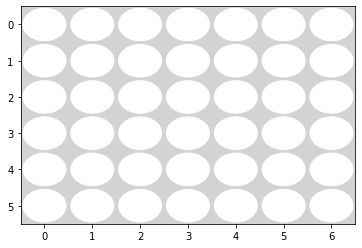

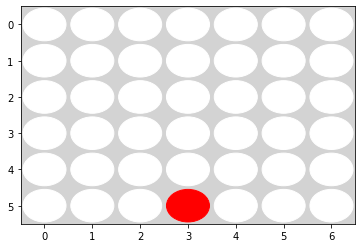

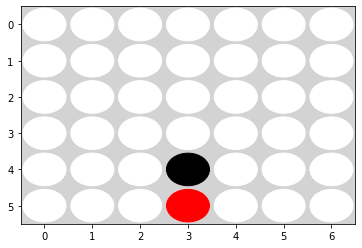

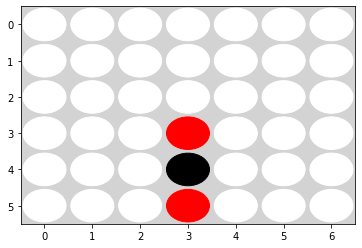

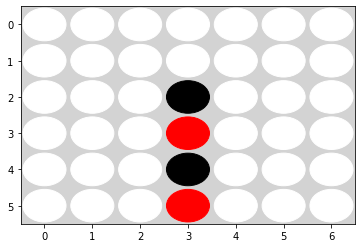

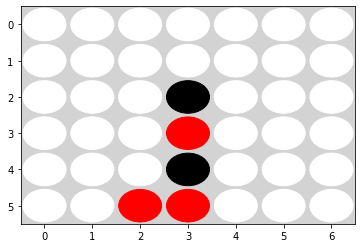

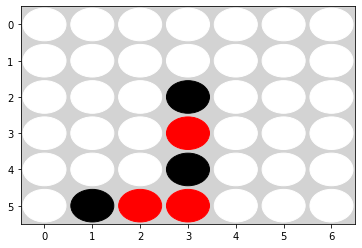

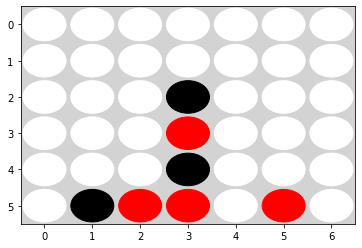

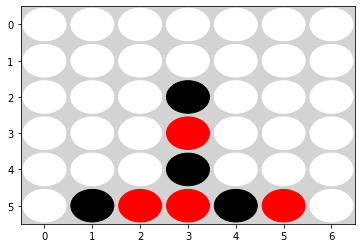

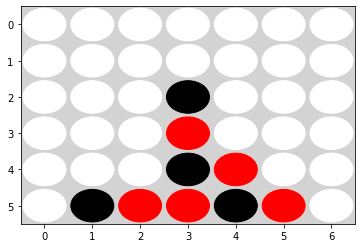

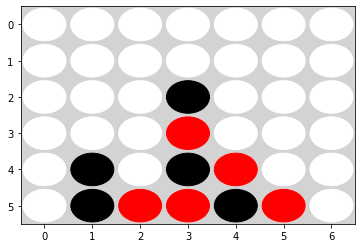

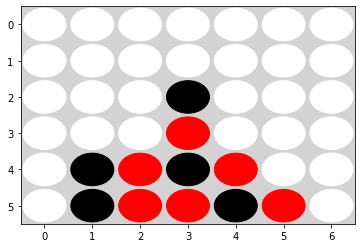

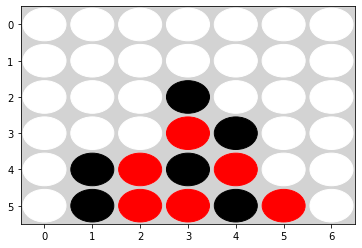

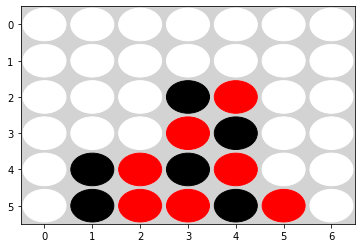

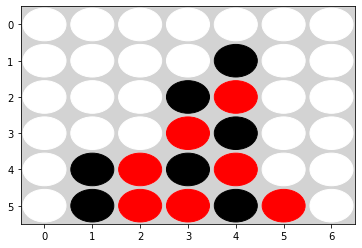

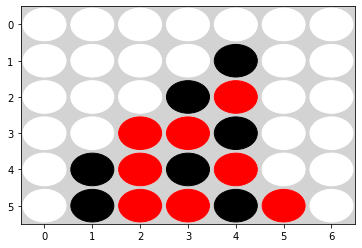

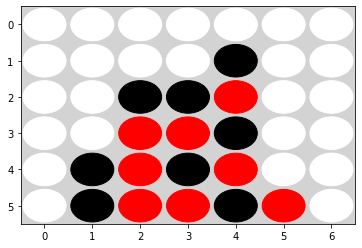

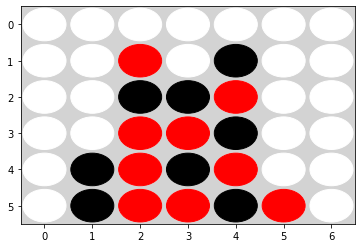

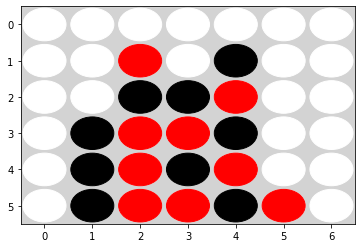

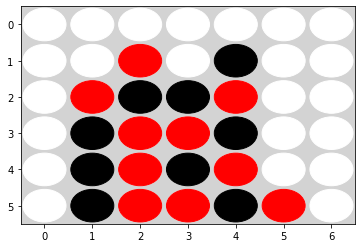

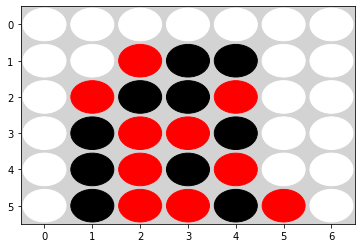

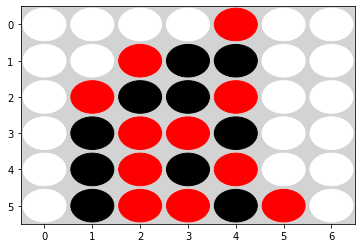

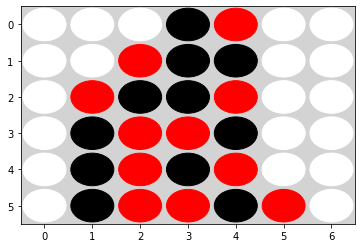

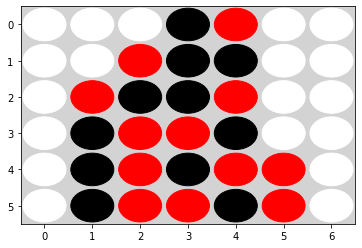

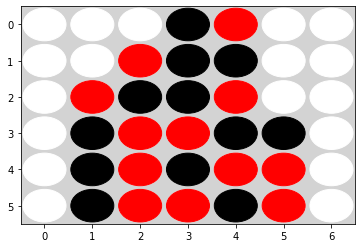

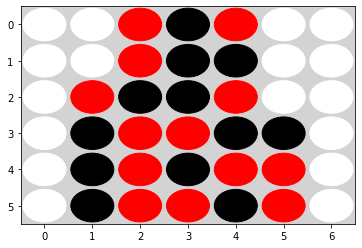

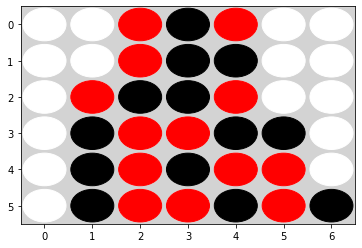

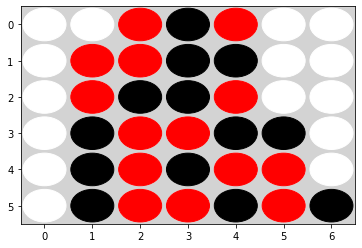

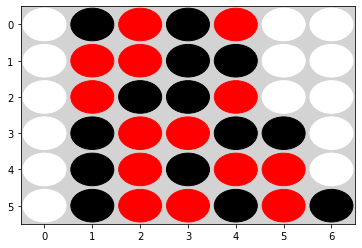

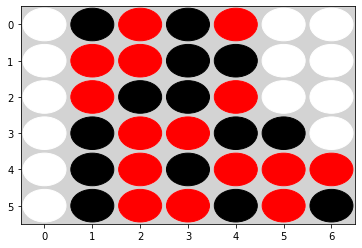

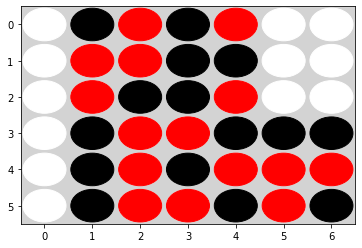

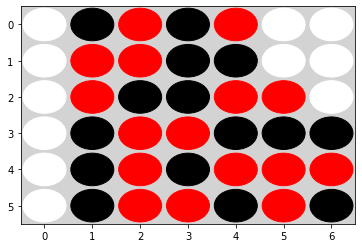

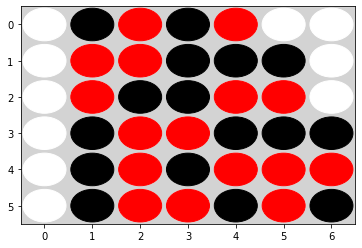

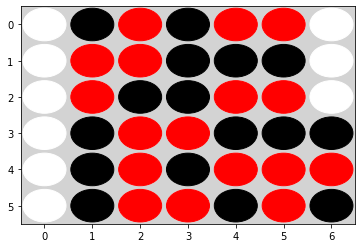

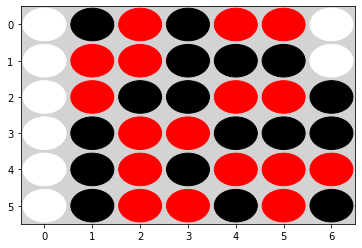

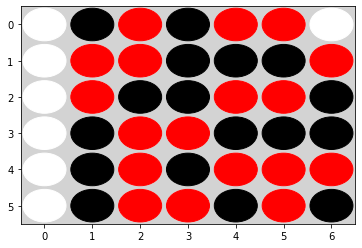

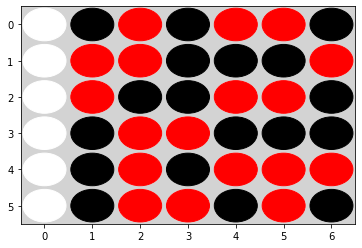

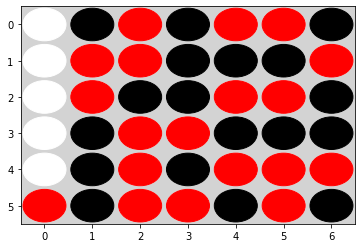

The Black player wins!


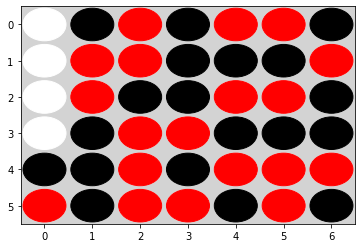

1

In [129]:
simulateGame([rolloutAI,rolloutAI_slow],verbose=True)